# Projet Numérique Florent Escribe - Arsène Ferrière

Ce projet numérique vise à produire un algorithme qui dessine les lignes de niveaux d'une fonction de $\mathbb{R}^2$ dans $\mathbb{R}$

## Déroulement
La méthode préconisée est de trouver un premier point de la ligne de niveau que l'on cherche puis de **l'approximer par une ligne brisée** qui se *propage* à partir de ce point.
Nous avons utilisés deux méthodes différentes pour propager la ligne.
- La première par une méthode dichotomique
- La seconde par la méthode de Newton sur une fonction appropriée de $\mathbb{R}^2$ dans $\mathbb{R}^2$

La même disjonction aurait pu être faite sur l'algorithme d'initialisation mais nous n'avons utilisé que la dichotomie car plus intuitive.

### Modules à importer

Numpy pour les opérations mathématiques et l'utilisation de vecteurs 

In [31]:
import autograd.numpy as np

Pyplot pour tracer les lignes que l'on met en inline pour le notebook

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

## L'initialisation : Recherche d'une graine

Ce premier exercice consiste a rechercher une ligne de niveau d'une fonction $f \in \mathcal{C}^1([0,1]^2,\mathbb{R})$ qui coupe le segment $[(0,0),(0,1)]$ (bord de gauche)

On est sûr et certain que la ligne de niveau de valeur c coupe cette arrête si $c \in$ $[f(0,0),f(0,1)]$ ou $[f(0,1),f(0,0)]$
en fonction de l'ordre.

**En effet**, 

Notons $g:[0,1] \to \mathbb{R}$ telle que $\forall y \in [0, 1]$, $g(y) = f(0,y)-c$, 

On obtient bien une fonction continue. De plus si l'on suppose (sans perdre de généralité quitte à utiliser -g) que $c \in$ $[f(0,0),f(0,1)]$ alors on a $g(0) \leq 0$ et $g(1) \geq 0$

Donc par Théorème des Valeurs Intermédiaires, $\exists$ $t \in [0,1],$ $g(t) = 0$

C'est à dire : $\exists$ $t \in [0,1],f(0,t) = c$

**Bien que la condition ne soit pas nécessaire à l'existence d'un tel point, on considèrera que si elle n'est pas réspectée, on ne peut pas trouver l'intersecton de la ligne de niveau avec le segment.**

Ainsi, si $c \notin$ $[f(0,0),f(0,1)]$  (respectivement $[f(0,1),f(0,0)]$), notre algorithme renvoie $None$

En revanche, si $c \in$ $[f(0,0),f(0,1)]$ (respectivement $[f(0,1),f(0,0)]$), on peut exécuter une dichotomie.

In [33]:
def find_seed(f,c=0,eps=2**-26):
    a,b = 0,1 
    if f(0,a) <= c <= f(0,b) or f(0,b) <= c <= f(0,a):
        while b-a > eps :
           mid = (b+a)/2
           if f(0,a) <= c <= f(0,mid) or f(0,mid) <= c <= f(0,a):      #il existe t dans l'intervalle [a,mid]
               b=mid
           else:
               a=mid
        res = (0,a)
    else:
        res = None
    return res

Le premier  $if$ vérifie si c est bien dans l'intervalle en verifiant les deux inégalités.
Si tel est le cas, on exécute la boucle while. La sortie de la boucle while est assuré car à chaque fois on divise b-a par 2. A terme, on a bien b-a < eps.

Une méthode de Newton aurait aussi fonctionné. 

**On a notre programme d'initialisation.**

## La propagation, une version simple.
Maintenant que l'on a un point de la ligne de niveau, on veut trouver les autres points. Pour que l'approximation soit bonne, on veut que les autres points soient à une distance d'environ $\delta$ que l'on prendra petit.

### 1ère méthode : Encore une dichotomie
    Notre première solution était de répeter le programme find_seed en x = $\delta$. Cela fonctionne bien tant que la courbe est plus ou moins horizontale. Cependant si la courbe devient presque verticale, on ne trouve plus de points à une distance $\delta$ du premier.

On veut maintenant s'assurer que le point $X_{n+1}$ que l'on recherche est sur sur le cercle de rayon $\delta$ et de centre $X_n$. *On suppose que la courbe ne s'arrete pas brutalement* pour s'assurer que la courbe a une intersection avec le cercle (en prenant $\delta$ suffisament petit).
Pour trouver $X_{n+1}$, on trace le cercle $\mathcal{C} (X_{n},\delta)$ puis on place deux points diametralement opposés sur le cercle. On les prends dans un premiers temps sur le diametre vertical. On procède ensuite par dichotomie sur l'angle formé par ces deux points jusqu'à encadrer $X_{n+1}$.

In [34]:
def dicho_angle_1(f,X,c,delta,eps):
    x, y = X[0], X[1]
    t_a=-np.pi/2
    t_b=np.pi/2
    while t_b-t_a > eps:
        t_milieu=(t_b+t_a)/2
        x_milieu , y_milieu = x + delta * np.cos(t_milieu) , y + delta * np.sin(t_milieu)
        x_a , y_a = x + delta * np.cos(t_a) , y + delta * np.sin(t_a)
        if f(x_milieu , y_milieu) <= c <= f(x_a , y_a) or f(x_milieu , y_milieu) >= c >= f(x_a , y_a):
            t_b = t_milieu
        else:
            t_a = t_milieu
    t_milieu=(t_a+t_b)/2
    x_milieu , y_milieu = x + delta * np.cos(t_milieu) , y + delta * np.sin(t_milieu)
    return (x_milieu , y_milieu)

Ce programme présente un problème. La dichotomie se fait toujours sur le coté droit du cercle car                           $t_{milieu} \in [{-\pi}/{2},{\pi}/{2}] $.

De plus, si la courbe est trop verticale, il se peut qu'il y ai des problèmes car on fixe les deux premier points verticaux.

   **Il faut legèrement modifier la fonction.**

Dans cette fonction on règle ces deux problèmes. On suppose qu'on a déjà créé deux points sur la ligne de niveau et que $\delta$ est suffisament petit pour que la courbe ne varie pas trop de direction entre $X_{n}$ et $X_{n+1}$ (Hypothèse continuement différentiable). 
Dans ce cas la, on connait déjà grossièrement la position de $X_{n+1}$ car "ilsuffit de prolonger la droite ($X_{n-1}$,$X_{n}$) dans une approximation à l'ordre 1. 

On cherche notre nouveau point dans un cadran de 90° autour de $X_{n}$ + ($X_{n}$ - $X_{n-1}$) ( $\pi / 4$ au dessus et $\pi/4$ en dessous)


In [35]:
def dicho_angle_2(f,c,eps,delta,Liste_x,Liste_y): 
    (x1,y1)=Liste_x[-1],Liste_y[-1]
    (x2,y2)=Liste_x[-2],Liste_y[-2]
    teta=np.arccos((x1-x2)/delta) * (y1-y2)/np.abs(y1-y2)   # est l'angle formé par le vecteur X2-X1 avec l'horizontale

                                                            #cos(teta) = (x1-x2)/delta
                                                           #(y1-y2)/np.abs(y1-y2) donne le signe de teta car arcos toujours positif
    t_a = teta - np.pi / 4
    t_b = teta + np.pi / 4

    while t_b-t_a>eps:
        t_milieu = (t_b + t_a) / 2
        
        x_milieu , y_milieu = x1 + delta * np.cos(t_milieu) , y1 + delta * np.sin(t_milieu)
        x_a , y_a = x1 + delta * np.cos(t_a) , y1 + delta * np.sin(t_a)
        if f(x_milieu , y_milieu) <= c <= f(x_a , y_a) or f(x_milieu , y_milieu) >= c >= f(x_a , y_a):
            t_b = t_milieu
        else:
            t_a = t_milieu

    t_milieu=(t_a+t_b)/2

    x_milieu , y_milieu = x1 + delta * np.cos(t_milieu) , y1 + delta * np.sin(t_milieu)

    return (x_milieu , y_milieu)

Il ne reste donc qu'à créer les 2 premiers points. Le premier par **find_seed**, le second par dichotomie en initialisant à la verticale (on sait que la courbe va aller a droite du cadran) ; c'est le programme **dicho_angle_1**.

In [36]:
def simple_contour_dichotomie(f,c,delta = 0.01,eps = 2**(-26)):
    X0=find_seed(f,c,eps)
    if X0 is None:
        return ([],[])
    liste_x,liste_y = [0.0],[X0[1]]

    X1 = dicho_angle_1(f,X0,c,delta,eps)

    liste_x.append(X1[0])
    liste_y.append(X1[1])

    X=dicho_angle_2(f,c,eps,delta,liste_x,liste_y)
    while 0 <= X[0] <= 1 and 0 <= X[1] <= 1:
        liste_x.append(X[0])
        liste_y.append(X[1])
        X=dicho_angle_2(f,c,eps,delta,liste_x,liste_y)
    return (liste_x,liste_y)

#### Vérifions que tout fonctionne bien.
D'abord quelques fonctions pour essayer.

In [37]:
def f1(x,y):
    return x**2 + y**2

def f2(x,y):
    return 2*(np.exp(-x**2-y**2)-np.exp(-(x-1)**2-(y-1)**2))

In [38]:
X,Y = simple_contour_dichotomie(f1, 1,0.01,2**(-26)) #on s'attend à avoir un quart de cercle
#vérifions
X_vrai = np.linspace(0,1,1000)
Y_vrai = np.sqrt(np.ones(1000)-X_vrai**2)

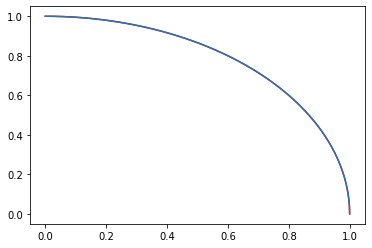

In [39]:
plt.plot(X_vrai,Y_vrai,color ='r')
plt.plot(X,Y)

plt.show()

In [40]:
X0,Y0 = simple_contour_dichotomie(f2,0)
X05,Y05 = simple_contour_dichotomie(f2,0.5)
X1,Y1 = simple_contour_dichotomie(f2,1)
X15,Y15 = simple_contour_dichotomie(f2,1.5)

L'écart entre la valeur attendue et la courbe produite n'est pas visible. En effet, il est inférieur a $\epsilon$, il est aussi petit que l'on veut.

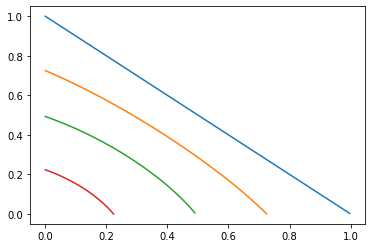

In [41]:
plt.plot(X0,Y0)
plt.plot(X05,Y05)
plt.plot(X1,Y1)
plt.plot(X15,Y15)
plt.show()

On a encore une fois bel et bien les courbes souhaitées.  

## Deuxième méthode: Newton !
Bien que la première méthode fonctionne parfaitement et soit très efficace (méthode dichotomique converge très vite), elle n'est pas dans l'esprit du cours.
Une autre méthode, qui elle aussi converge très vite est plus dans le thème. C'est la **méthode de Newton**.

On garde la même fonction **find_seed** car elle ne dépend pas de la méthode choisie.

Dans un premier temps nous avons utilisé des fonctions de différenciation "faites maisons":

In [42]:
def jacobien(g,X, h=2**(-25)):
    x,y = X[0],X[1]
    dx , dy = np.array([h,0]) , np.array([0,h])
    dx_gx = (g(X+dx)[0]-g(X)[0])/h
    dx_gy = (g(X+dx)[1]-g(X)[1])/h
    dy_gx = (g(X+dy)[0]-g(X)[0])/h
    dy_gy = (g(X+dy)[1]-g(X)[1])/h

    J = np.array([[dx_gx, dy_gx],[dx_gy,dy_gy]])
    return J

Cette fonction créé le jacobien de $g \in \mathcal{C}^1(\mathbb{R}^2,\mathbb{R}^2)$

Cependant le cours suggère l'utilisation de autograd pour cette fonction.

In [43]:
import autograd as atg

In [44]:
def jacob_auto(g,X):
    x,y = X[0],X[1]
    return np.c_[atg.jacobian(g, 0)(x, y), atg.jacobian(g, 1)(x, y)]

### Comment fonctionne cet algorithme ?

Suposons que l'on a deja un point $X_{n}$ de la courbe de niveau.

Comme pour la méthode précedente on cherche un point qui est à la fois sur la courbe et sur le cercle $\mathcal{C} (X_{n},\delta)$, de centre $X_{n}$ et de rayon $\delta$. On introduit donc une fonction $g:[0,1]^2 \to \mathbb{R}^2$ 
telle que : $\forall (x,y) \in \mathbb{R}^2$,  $g \left( \begin{array}{c} x \\ y \end{array} \right) = \left( \begin{array}{c} f(x)-c \\ (x-x_{n})^2 + (y-y_n)^2 -\delta^2 \end{array} \right) $.

La méthode de Newton permet de trouver un zéro de cette fonction par le théorème du point fixe.
Si l'on obtient un 0,on a alors $f\left( \begin{array}{c} x \\ y \end{array} \right) = c$ et $(x-x_{n})^2 + (y-y_n)^2 = \delta^2$ donc $X_{n+1} = \left( \begin{array}{c} x \\ y \end{array} \right)$ est a une distance $\delta$ de $X_n$ et est sur la ligne de niveau.

In [45]:
def newton(g,X_0,eps=2**(-26)): #g prend 2 arguments et vas dans R2
    X = X_0
    x,y = X
    J=jacob_auto(g,X)
    J_inv = np.linalg.inv(J)
    Xnew = X - np.matmul( g(x,y) , np.transpose(J_inv))
    while np.linalg.norm(X-Xnew) >= eps:
        x,y = Xnew
        J=jacob_auto(g,Xnew)
        J_inv = np.linalg.inv(J)
        X, Xnew =Xnew, Xnew - np.matmul( g(x,y) , np.transpose(J_inv))
    return Xnew

La méthode de newton consiste en une recherche de point fixe de la fonction $X \mapsto X-J_{f}(X)^{-1}.f(X)$
En effet si un tel point fixe existe on a $f(X) = 0$
Dans notre algorithme, on ne s'est pas préocupé de savoir si la matrice est inversible car l'ensemble des matrices inversibles est dense dans l'ensemble des matrices. Il serait peu chanceux qu'elle ne soit pas inversible. Nous verrons que cela peut poser problème.

In [46]:
def nouveau_point(f,X_old,direction,c=0.0,delta=0.01,eps= 2**(-26)):
    x_old,y_old = X_old[0],X_old[1]
    def g(x,y):
        return np.array([f(x,y)-c, (x-x_old)**2+(y-y_old)**2-delta**2])
    new_point = newton(g,X_old + np.array([delta,0]),eps)
    return new_point

On peut dorrénavant trouver notre nouveau point.
La variable direction permet, pour les mêmes raisons que dans l'algorithme de dichotomie, de s'approcher plus près de $X_{n+1}$ par une approximation du premier ordre.

#### Arrive maintenant l'algorithme final

In [47]:
def simple_contour_newton_erreur(f,c=0.0, delta= 0.01,eps = 2**(-26)):
    listeX,listeY=[],[]
    X_n = find_seed(f,c,eps)
    if X_n is None:
        return [],[]
    listeX.append(X_n[0])
    listeY.append(X_n[1])
    direction = np.array([-delta,0])
#On s'approche au départ de la droite puisqu'on sait que notre courbe par initialement sur la droite.
    X_n1 = nouveau_point(f,X_n,direction,c,delta,eps)
    listeX.append(X_n1[0])
    listeY.append(X_n1[1])
    while 0 <= X_n[0] <= 1 and 0 <= X_n[1] <= 1:
        direction = X_n1 - X_n
        X_n, X_n1 = X_n1, nouveau_point(f,X_n,direction,c,delta,eps)
        listeX.append(X_n1[0])
        listeY.append(X_n1[1])
    return listeX,listeY

Essayons de traiter le cas ou une matrice singulière apparait.
Si tel est le cas, on arrête la procédure et on renvoie ce qu'on a   

In [61]:
def simple_contour_newton(f,c=0.0, delta= 0.01,eps = 2**(-26)):
    listeX,listeY=[],[]
    X_n = find_seed(f,c,eps)
    if X_n is None:
        return [],[]
    listeX.append(X_n[0])
    listeY.append(X_n[1])
    direction = np.array([-delta,0])
#On s'approche au départ de la droite puisqu'on sait que notre courbe par initialement sur la droite.
    X_n1 = nouveau_point(f,X_n,direction,c,delta,eps)
    listeX.append(X_n1[0])
    listeY.append(X_n1[1])
    while 0 <= X_n[0] <= 1 and 0 <= X_n[1] <= 1:
        direction = X_n1 - X_n
        try:
            X_n, X_n1 = X_n1, nouveau_point(f,X_n,direction,c,delta,eps)
        except np.linalg.LinAlgError:
            return listeX,listeY
        listeX.append(X_n1[0])
        listeY.append(X_n1[1])
    return listeX,listeY

In [48]:
X3,Y3 = simple_contour_newton(f1, 1 , 0.001) 
print(X3)
#on s'attend à avoir un quart de cercle
#vérifions
X_vrai = np.linspace(0,1,1000)
Y_vrai = np.sqrt(np.ones(1000)-X_vrai**2)

[0, 0.0009999998823395548, 0.0009999998823395548, 0.001999998757340294, 0.001999998757340294, 0.0029999956323465255, 0.0029999956323465255, 0.003999989507370999, 0.003999989507370999, 0.004999979382438465, 0.004999979382438465, 0.005999964257475291, 0.005999964257475291, 0.0069999431325478605, 0.0069999431325478605, 0.007999915007677296, 0.007999915007677296, 0.008999878882891724, 0.008999878882891724, 0.00999983375822727, 0.00999983375822727, 0.010999778633729057, 0.010999778633729057, 0.01199971250945221, 0.01199971250945221, 0.012999634385462856, 0.012999634385462856, 0.013999543261839114, 0.013999543261839114, 0.01499943813867211, 0.01499943813867211, 0.01599931801606697, 0.01599931801606697, 0.01699918189414381, 0.01699918189414381, 0.017999028773038758, 0.017999028773038758, 0.018998857652904932, 0.018998857652904932, 0.019998667533913453, 0.019998667533913453, 0.020998457416254442, 0.020998457416254442, 0.021998226300138014, 0.021998226300138014, 0.022997973185795287, 0.02299797

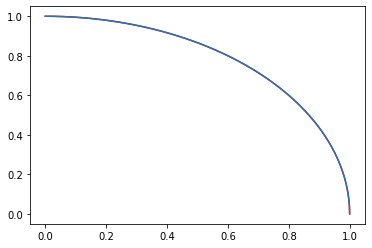

In [49]:
plt.plot(X_vrai,Y_vrai,color ='r')
plt.plot(X,Y)
plt.show()

In [50]:
X0,Y0 = simple_contour_newton(f2,0)
X05,Y05 = simple_contour_newton(f2,0.5)
X1,Y1 = simple_contour_newton(f2,1)
X15,Y15 = simple_contour_newton(f2,1.5)

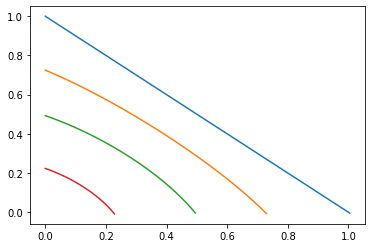

In [51]:
plt.plot(X0,Y0)
plt.plot(X05,Y05)
plt.plot(X1,Y1)
plt.plot(X15,Y15)
plt.show()

**Encore une fois, tout semble fonctionner!**

# Elargissons notre horizon 

Nous voulons maintenant Tracer les lignes de niveaux de la fonction sur un ensemble de définition plus grand et qui ne sont pas forcément en contact avec le bord gauche. On regarde sur tous les côtés.

On ne va pas créer un autre algorithme mais plutôt adapter notre donction pour qu'elle soit définie sur $[0,1]^2$


In [52]:
def rotation90(x,y):
    omega = np.array([[0.0,-1.0],[1.0,0.0]])
    Xres = np.array([0.5,0.5]) + np.matmul(np.array([x-0.5,y-0.5]),np.transpose(omega))
    return (Xres[0],Xres[1])

Le fonction ci-dessus est une rotation affine de centre $(0.5,0.5)$ et d'angle $pi/2$.
Elle permet de tester chacune des arrêtes en faisant une rotation du plan.

In [53]:
def contour_complexe_dichotomie(f, c= 0.0, xc = [0.0,1.0], yc = [0.0,1.0], delta = 0.01,eps = 2**(-24)):
    Xres,Yres = [],[]
    for i_x,xi in enumerate(xc[:-1]):
        for i_y,yi in enumerate(yc[:-1]):
            lx = xc[i_x+1] - xi
            ly = yc[i_y+1] - yi
            for side in range(4):
                def f_calibre(x,y):
                    xn,yn = x*lx+xi , y*ly+yi          
#ici on adapte la taille de l'intervalle pour qu'il fasse du 1x1et on le deplace pour qu'il arrive sur notre carré
                    for i in range(side):
                        xn,yn = rotation90(xn,yn)
                    return f(xn,yn)
                X_cote,Y_cote = simple_contour_dichotomie(f_calibre,c,delta,eps)
                Xbien,Ybien = [],[]
                for x,y in zip(X_cote,Y_cote):
                    xn , yn = x*lx + xi,y*ly + yi
                    for i in range(side):
                        xn,yn = rotation90(xn,yn)
                    Xbien.append(xn)
                    Ybien.append(yn)
                Xres.append(np.array(Xbien))
                Yres.append(np.array(Ybien))
    return (Xres,Yres)

**Bien entendu l'algorithme fonctionne aussi avec la méthode de newton**

In [63]:
def contour_complexe_newton(f, c= 0.0, xc = [0.0,1.0], yc = [0.0,1.0], delta = 0.05,eps = 2**(-20)):
    Xres,Yres = [],[]
    for i_x,xi in enumerate(xc[:-1]):
        for i_y,yi in enumerate(yc[:-1]):
            lx = xc[i_x+1] - xi
            ly = yc[i_y+1] - yi
            for side in range(4):
                def f_calibre(x,y):
                    xn,yn = x*lx+xi , y*ly+yi          
#ici on adapte la taille de l'intervalle pour qu'il fasse du 1x1et on le deplace pour qu'il arrive sur notre carré
                    for i in range(side):
                        xn,yn = rotation90(xn,yn)
                    return f(xn,yn)
                X_cote,Y_cote = simple_contour_newton(f_calibre,c,delta,eps)
                Xbien,Ybien = [],[]
                for x,y in zip(X_cote,Y_cote):
                    xn , yn = x*lx + xi,y*ly + yi
                    for i in range(side):
                        xn,yn = rotation90(xn,yn)
                    Xbien.append(xn)
                    Ybien.append(yn)
                Xres.append(np.array(Xbien))
                Yres.append(np.array(Ybien))
    return (Xres,Yres)

Ici, nous deplaçons le plan pour ajuster le rectangle $[x_i,x_{i+1}] \times [y_i,y_{i+1}]$ sur le carré $[0,1] \times [0,1]$. Ensuite on tourne le carré autour de son centre de 90° 4 fois pour faire les mesures sur chacun des cotés.

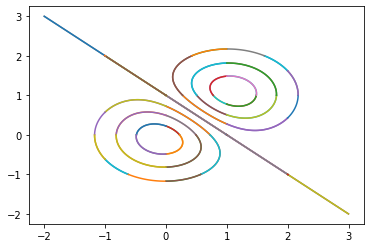

In [55]:
for i in range(-3,4):
    X,Y = contour_complexe_dichotomie(f2,i/2,[-3,-2,-1,0,1,2,3],[-2,-1,0,1,2])
    for x,y in zip(X,Y):
        plt.plot(x,y)
    





plt.show()

In [64]:
for i in range(-3,4):
    X,Y = contour_complexe_newton(f2,i/2,[-3,-2,-1,0,1,2,3],[-2,-1,0,1,2])
    for x,y in zip(X,Y):
        plt.plot(x,y)
    




KeyboardInterrupt: 

In [66]:
Le programme tourne dans le vide...